In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 15, 5

In [2]:
headers = ['SP', 'HIP', 'HCP', 'OPT', 'NS', 'NT', 'WHM',
           'PI', 'TM', 'VtoI', 'ItoC', 'AH', 'QInv']

# here we add a _-suffixed header after each header
# [sp, hip, ...] becomes [sp, sp_sent, hip, hip_sent, ...]
headers = ['language', 'idk'] + [h.lower()
 for header in headers
 for h in (header, header + '_sent')]
headers[:5]

['language', 'idk', 'sp', 'sp_sent', 'hip']

# Reading the csv

- there is no sentence value column for QInv.

-  I don't know what the second column represents (I've named it idk).

In [3]:
data = pd.read_csv('./simulation-output.csv', index_col=False, error_bad_lines=False)
data.columns = headers[:-1]

b'Skipping line 20768: expected 28 fields, saw 33\nSkipping line 20822: expected 28 fields, saw 46\nSkipping line 20859: expected 28 fields, saw 30\n'
b'Skipping line 44753: expected 28 fields, saw 48\nSkipping line 44801: expected 28 fields, saw 38\nSkipping line 44833: expected 28 fields, saw 37\n'
b'Skipping line 198236: expected 28 fields, saw 46\nSkipping line 199673: expected 28 fields, saw 52\nSkipping line 199686: expected 28 fields, saw 31\nSkipping line 199715: expected 28 fields, saw 44\n'
b'Skipping line 238417: expected 28 fields, saw 38\nSkipping line 238433: expected 28 fields, saw 30\nSkipping line 238448: expected 28 fields, saw 32\nSkipping line 238464: expected 28 fields, saw 34\nSkipping line 238479: expected 28 fields, saw 30\nSkipping line 238528: expected 28 fields, saw 38\nSkipping line 254582: expected 28 fields, saw 46\n'
/home/paul/.virtualenvs/colag/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,4,10) have mixed t

~15 of the lines have too many columns

These two have blank language fields (note that the index number will not correspond to the line number, since the ill-formed lines above were ommitted. so I guess the line number should be the index + ~15).

In [4]:
data[pd.isnull(data.language)]

,language,idk,sp,sp_sent,hip,hip_sent,hcp,hcp_sent,opt,opt_sent,...,pi_sent,tm,tm_sent,vtoi,vtoi_sent,itoc,itoc_sent,ah,ah_sent,qinv
44839,NaN,1.377889e-95,14160,0.5,-1,6.491499e-213,6365.0,0.5,-1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199717,NaN,-1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I'll drop them for now.

In [5]:
data = data[~pd.isnull(data.language)]

In [6]:
# the columns for just the learned paramter values
param_names = [p for p in data.columns
               if len(p) <= 4 and p != 'idk']

# the columns for the number of sentences consumed by the learner
sent_names = [p for p in data.columns
               if '_' in p]

let's convert all the columns to floats

In [7]:
for param in data.columns:
    data[param] = pd.to_numeric(data[param], errors='coerce')
len(data) - len(data.dropna(how='any', axis='index'))

16

16 rows had values that were malformed and failed numeric conversion.

the language ids are easier to work with as strings than floats.

In [8]:
data['language'] = data.language.astype(int).astype(str)

# Dataset Sanity Check

## Parameter Values

The echild-learned param values should fall between 0 and 1. Let's see how many values are > 1 for each param.

In [9]:
(
    data[param_names]
    .gt(1)
    .sum()
    .sort_values(ascending=False)
)

whm     4
nt      2
ns      2
opt     2
sp      2
vtoi    1
tm      1
pi      1
hcp     1
qinv    0
ah      0
itoc    0
hip     0
dtype: int64

That's not good. Something's up with the output. Let's just drop them for now.

In [10]:
valid_rows = (
    data[param_names]
    .gt(1).replace(True, np.nan)
    .dropna()
).index
len(data) - len(valid_rows)

6

we discard 6 rows.

In [11]:
data = data.loc[valid_rows]

so now we're only looking at data that falls between 0-1

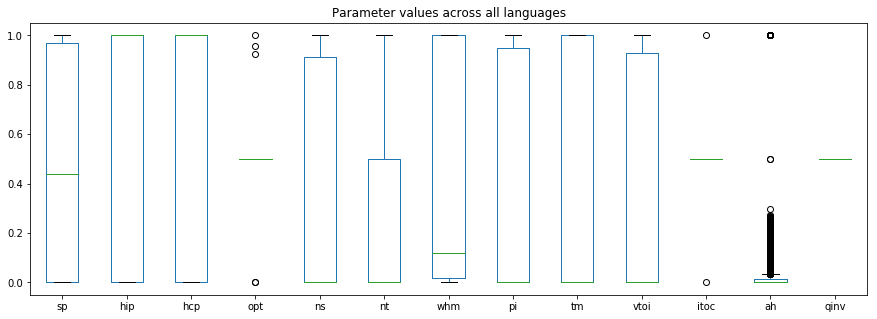

In [23]:
data[param_names].plot.box(title='Parameter values across all languages');


# Parameter Distribution Sanity Test

We want to assert that the distribution of per-language parameters learned by echildren look sane.

By sane here we mean that in a given language, the echild-learned values for a single parameter all either
- fall within 0.01 of 1
- fall within 0.01 of 0
- all exist in the ambiguous zone from 0.01 to 0.99

In [15]:
def bad_param(param, left_bound=0.01, right_bound=0.99):
    """ 
    Returns 1 if the distribution of the parameter values in series `param` is problematic.
    Returns nan otherwise.
    
    `param` is a series of parameter values for a single parameter in a 
    single language, from all echildren.
    
    A distribution is considered problematic when there are values on both sides
    of the left and/or right threshold. If all values fall to the right of the right threshold,
    to the left of the left threshold, or no values cross either threshold, then it's fine.
    
    """
    problem = (
        (param <= left_bound).any() and (param > left_bound).any()
        or
        (param >= right_bound).any() and (param < right_bound).any())
    if problem:
        return 1

In [20]:
plt.rcParams['figure.figsize'] = 15, 5

def plot_params(df, language):
    """ Make a box plot of the parameters learned by all echildren for the 
    language with language-id `language`. 
    """
    
    target = df[df.language.eq(language)]
    target[param_names].plot.box(title='Learned Params (language {})'.format(language));
    plt.xticks(range(1, 14), param_names);

## Problematic Distributions

In [17]:
# the languages for which we observe problematic distributions
problematics = (
    data
    .groupby('language')
    [param_names]
    .apply(lambda lang: lang.apply(bad_param, axis='index'))
    # discard the rows for which none of the params are problematic
    .dropna(axis='index', how='all')
)
len(problematics)

937

so 937 of the languages are displaying problematic distributions.

Here's how often each parameter is the problematic one

In [18]:
problematics.sum().sort_values(ascending=False)

whm     770.0
ah      211.0
pi       72.0
ns       14.0
vtoi      3.0
tm        3.0
nt        3.0
opt       3.0
hcp       2.0
itoc      1.0
hip       1.0
sp        NaN
qinv      NaN
dtype: float64

## Problematic Languages

Here are plots of the distribution of learned parameters for the problematic languages.

I've limited it to the first 20 languages, ordered by level of skewness in the distribution.

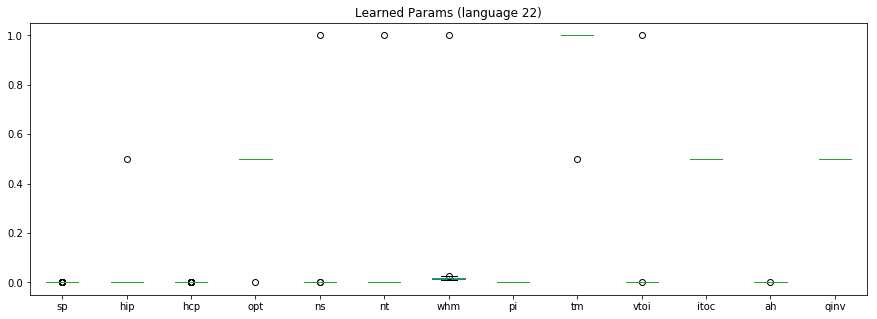

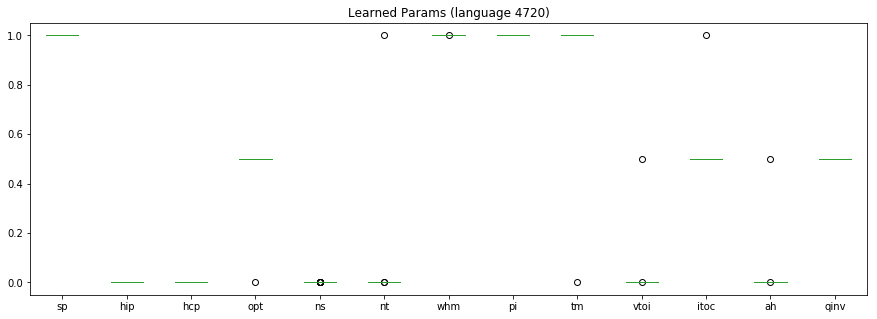

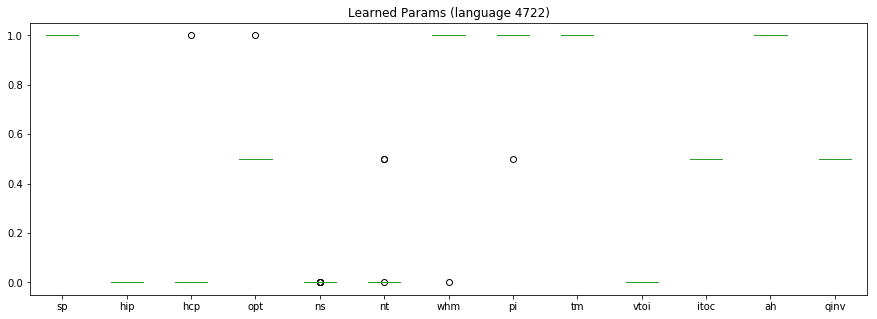

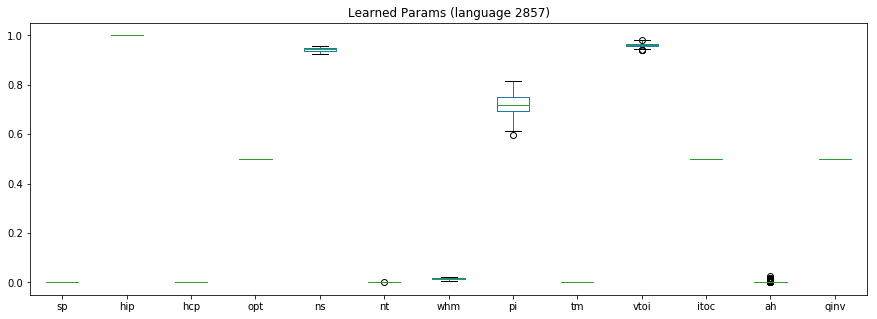

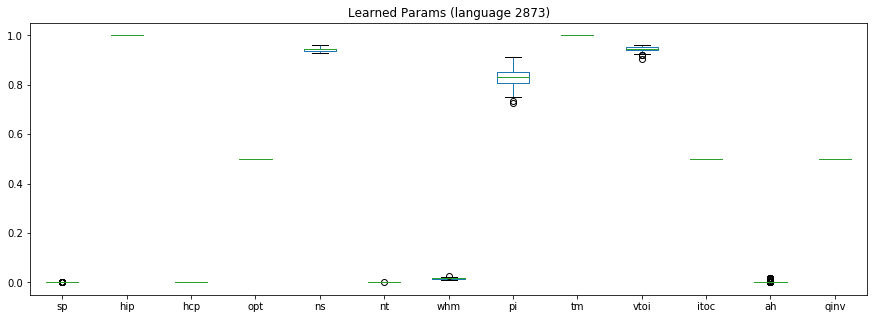

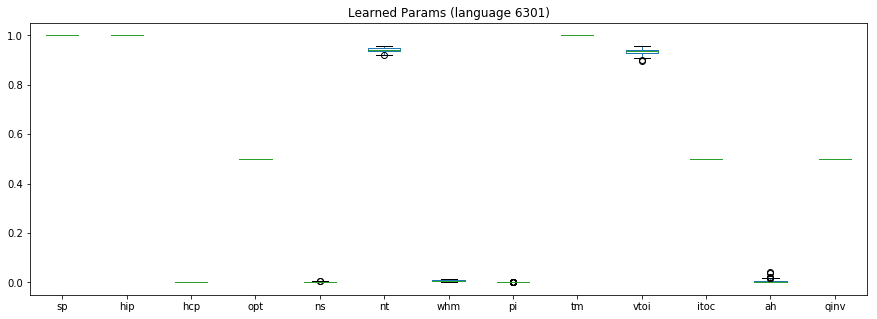

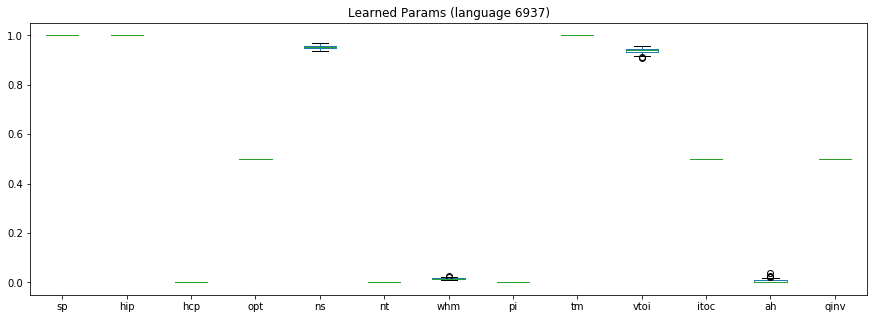

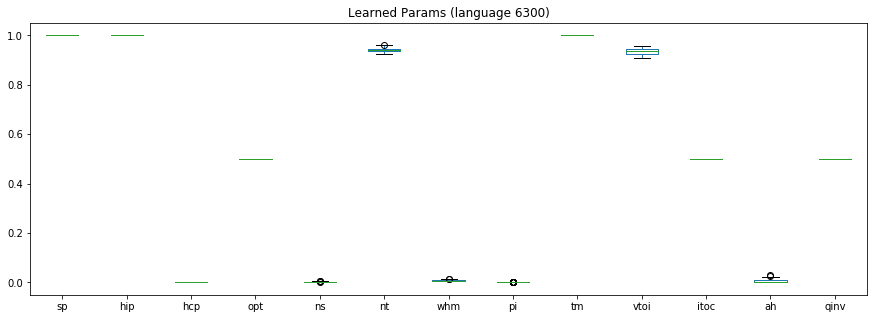

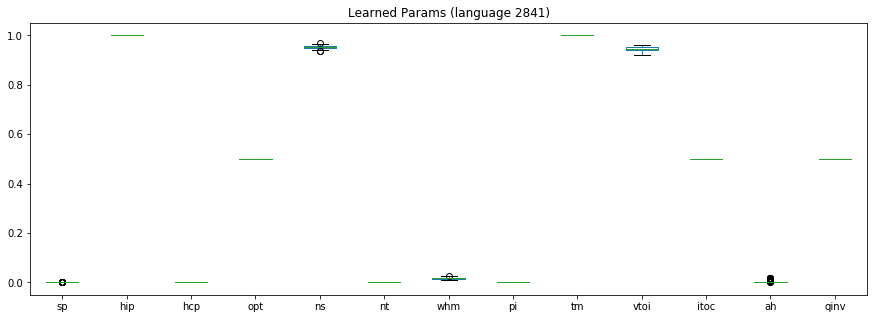

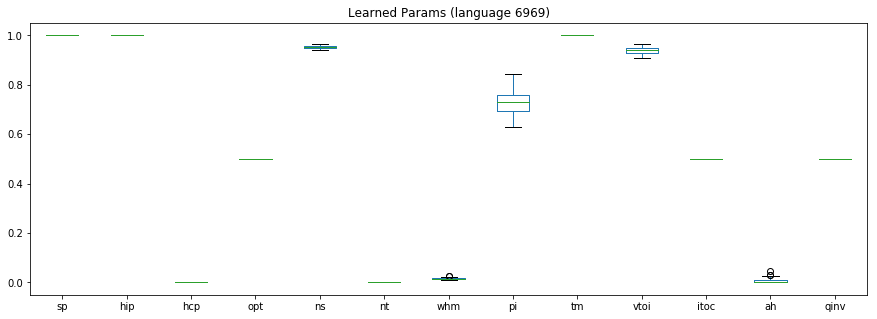

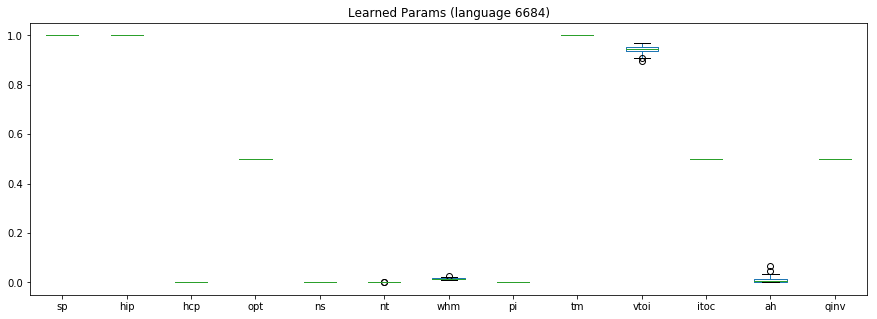

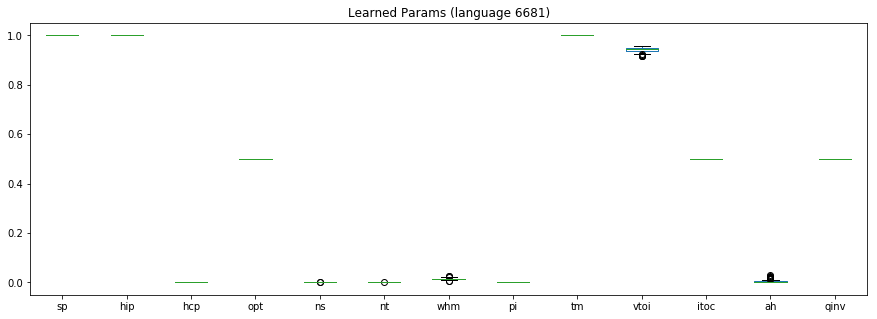

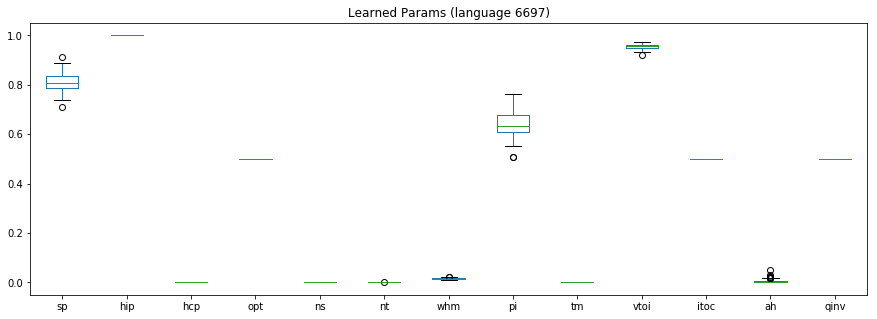

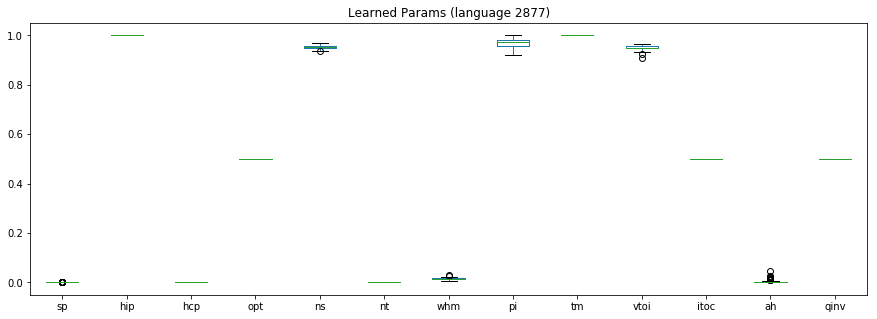

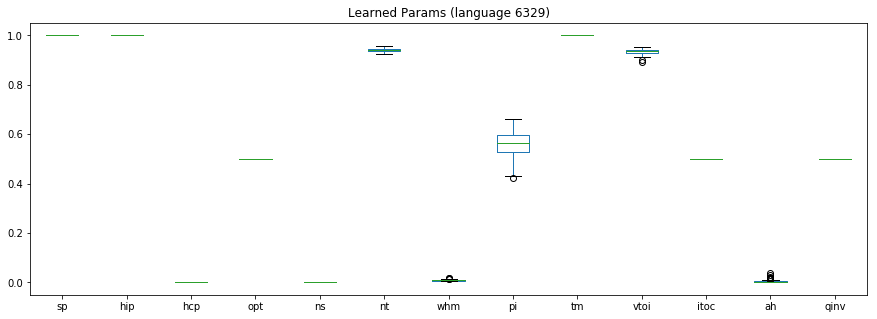

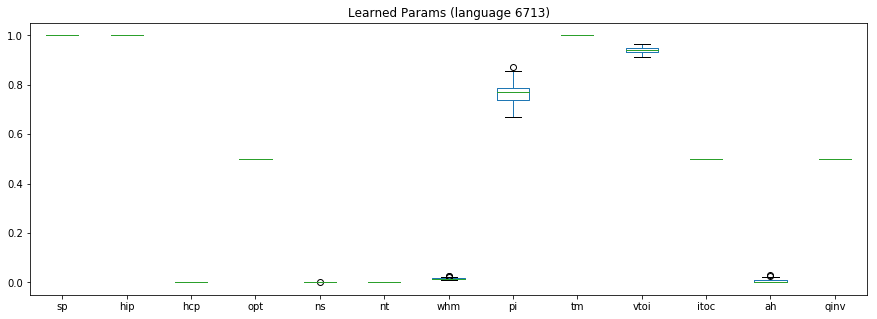

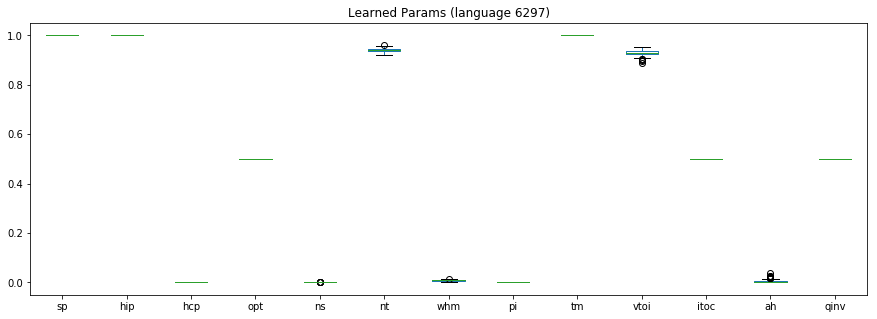

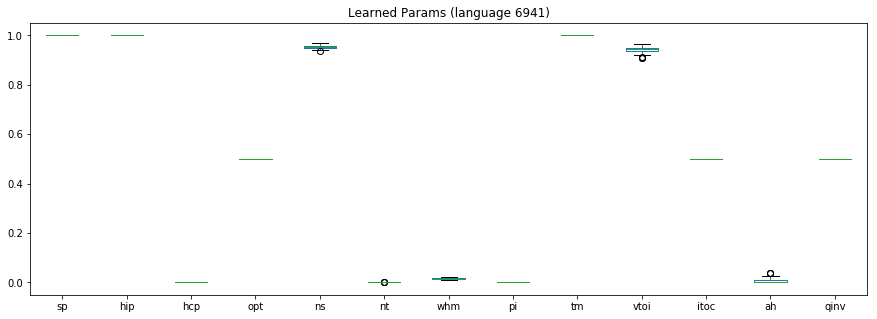

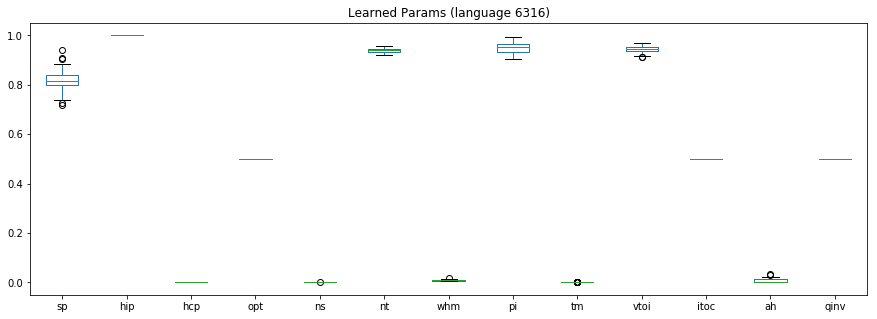

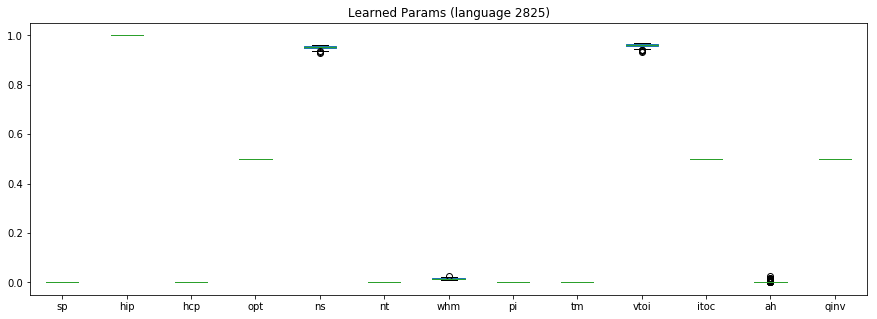

In [21]:
bad_languages = (data
 [data.language.isin(problematics.index)]
 .groupby('language')
 [param_names]
 .apply(lambda df: df.skew().mean())
 .sort_values(ascending=False)
 .index
)

for language in bad_languages[:20]:
    plot_params(data, language)